# **02 - Data Exploration and Cleaning**

## Objectives

* Clean the dataset to ensure it is ready for analysis and modeling.
* Handle missing values, outliers, and inconsistent data.
* Optimize data types for better performance.
* Save the cleaned dataset for further analysis.

## Inputs

* The cleaned dataset with categorical columns: `inputs/datasets/raw/house_prices_records.csv`.

## Outputs

* An updated cleaned dataset saved as: `outputs/datasets/cleaned/house_prices_cleaned.parquet`.

## Additional Comments
Due to issues with the `GarageFinish` column, where no missing values were present before saving but 235 missing values appeared when the saved file was loaded as a `.csv`, we have decided to use the `.parquet` format instead. Parquet preserves data types and handles missing values more reliably than CSV, ensuring the integrity of the cleaned dataset.

---

## Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [93]:
import os
current_dir = os.getcwd()
current_dir

'd:\\Projects\\milestone-project-heritage-housing-issues'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [94]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [95]:
current_dir = os.getcwd()
current_dir

'd:\\Projects'

## Section 1: Load data

We import the Pandas library to work with tabular data and load the dataset from `inputs/datasets/raw/house_prices_records.csv`. The `.shape` attribute provides the number of rows and columns, and `.head(5)` previews the first 5 rows to verify the data.

In [97]:
import pandas as pd

df_prices = pd.read_csv("inputs/datasets/raw/house_prices_records.csv")

print("Shape of the dataset:", df_prices.shape)
df_prices.head(5)

Shape of the dataset: (1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

## Section 2: Data Exploration

We identify columns with missing values, sort them in descending order, and create a table showing the number and percentage of missing values for each column. This helps prioritize data cleaning efforts.

In [98]:
missing_values = df_prices.isnull().sum()
missing_data = missing_values[missing_values > 0].sort_values(ascending=False)

missing_data_df = pd.DataFrame({
    "Column": missing_data.index,
    "Missing Values": missing_data.values,
    "Percentage": (missing_data.values / len(df_prices) * 100).round(2),
    "Datatype": [df_prices[col].dtype for col in missing_data.index]
})

missing_data_df

,Column,Missing Values,Percentage,Datatype
0,EnclosedPorch,1324,90.68,float64
1,WoodDeckSF,1305,89.38,float64
2,LotFrontage,259,17.74,float64
3,GarageFinish,235,16.10,object
4,BsmtFinType1,145,9.93,object
5,BedroomAbvGr,99,6.78,float64
6,2ndFlrSF,86,5.89,float64
7,GarageYrBlt,81,5.55,float64
8,BsmtExposure,38,2.60,object
9,MasVnrArea,8,0.55,float64


We use `ydata_profiling` to generate a detailed report for columns with missing values. This helps us understand the distribution, patterns, and potential issues in these columns, guiding our data cleaning process.

In [99]:
from ydata_profiling import ProfileReport

vars_with_missing_data = missing_data.index.tolist()

if vars_with_missing_data:
    profile = ProfileReport(df=df_prices[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

ImportError: cannot import name 'display' from 'IPython.core.display' (d:\Projects\milestone-project-heritage-housing-issues\.venv\Lib\site-packages\IPython\core\display.py)

## Section 3: Data Cleaning

### 1. Handling missing values

Fill missing values and checking no missing values remain:
* `LotFrontage`, `BedroomAbvGr`, `MsnVnrArea`: Filled missing value with the median to handle skewed distribution.
*  `BsmtExposure`: Filled missing values with 'No' to indicate no basement exposure.
*  `BsmtFinType1`: Filled missing values with 'Unf'  to indicate no finished basement.
*  `GarageFinish`: Filled missing values with 'None' to indicate no finished garage.
*  `2ndFlrSF`, `GarageYrBlt`: Filled missing values with '0' to indicate no second floor/garage.

In [100]:
df_prices['LotFrontage'].fillna(df_prices['LotFrontage'].median(), inplace=True)
df_prices['BedroomAbvGr'].fillna(df_prices['BedroomAbvGr'].median(), inplace=True)
df_prices['MasVnrArea'].fillna(df_prices['MasVnrArea'].median(), inplace=True)
df_prices['BsmtExposure'].fillna('No', inplace=True)
df_prices['BsmtFinType1'].fillna('Unf', inplace=True)
df_prices['GarageFinish'].fillna('None', inplace=True)
df_prices['2ndFlrSF'].fillna(0, inplace=True)
df_prices['GarageYrBlt'].fillna(0, inplace=True)

print(df_prices.isnull().sum())



1stFlrSF            0
2ndFlrSF            0
BedroomAbvGr        0
BsmtExposure        0
BsmtFinSF1          0
BsmtFinType1        0
BsmtUnfSF           0
EnclosedPorch    1324
GarageArea          0
GarageFinish        0
GarageYrBlt         0
GrLivArea           0
KitchenQual         0
LotArea             0
LotFrontage         0
MasVnrArea          0
OpenPorchSF         0
OverallCond         0
OverallQual         0
TotalBsmtSF         0
WoodDeckSF       1305
YearBuilt           0
YearRemodAdd        0
SalePrice           0
dtype: int64


### 2. Dropping columns
Drop `EnclosedPorch` and `WoodDeckSF` since they have more than 80% missing values. 

In [101]:
df_prices.drop(columns=['EnclosedPorch', 'WoodDeckSF'], inplace=True)

---

## Section 4: Split data into train and test sets

Create new directory for cleaned datasets and save the cleaned dataset.

In [102]:
import os
try:
    os.makedirs(name='outputs/datasets/cleaned', exist_ok=True)
except Exception as e:
    print(e)

df_prices.to_parquet("outputs/datasets/cleaned/house_prices_cleaned.parquet", index=False)

Split data into train and test sets and provide the amount of rows and columns for each dataset.

In [103]:
from sklearn.model_selection import train_test_split

df_cleaned = pd.read_parquet("outputs/datasets/cleaned/house_prices_cleaned.parquet")
TrainSet, TestSet = train_test_split(
    df_cleaned,
    test_size=0.2,
    random_state=42)
print(f"Train set shape: {TrainSet.shape}")
print(f"Test set shape: {TestSet.shape}")

Train set shape: (1168, 22)
Test set shape: (292, 22)


Checking missing values in train and test set.

In [104]:
print(f"Missing values in TrainSet:\n{TrainSet.isnull().sum()}")
print(f"Missing values in TestSet:\n{TestSet.isnull().sum()}")

Missing values in TrainSet:
1stFlrSF        0
2ndFlrSF        0
BedroomAbvGr    0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtUnfSF       0
GarageArea      0
GarageFinish    0
GarageYrBlt     0
GrLivArea       0
KitchenQual     0
LotArea         0
LotFrontage     0
MasVnrArea      0
OpenPorchSF     0
OverallCond     0
OverallQual     0
TotalBsmtSF     0
YearBuilt       0
YearRemodAdd    0
SalePrice       0
dtype: int64
Missing values in TestSet:
1stFlrSF        0
2ndFlrSF        0
BedroomAbvGr    0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtUnfSF       0
GarageArea      0
GarageFinish    0
GarageYrBlt     0
GrLivArea       0
KitchenQual     0
LotArea         0
LotFrontage     0
MasVnrArea      0
OpenPorchSF     0
OverallCond     0
OverallQual     0
TotalBsmtSF     0
YearBuilt       0
YearRemodAdd    0
SalePrice       0
dtype: int64


---

## Section 5: Visualize Data Cleaning Effects

We are using the DataCleaningEffect function to visualize the impact of data cleaning on specific variables. This helps us:
1. Verify the cleaning process: Ensure that missing values have been handled correctly and that the data cleaning hasn't introduced any unexpected changes.
2. Compare original vs cleaned data: See how the distributions of variables have changed after cleaning.
3. Document the process: Provide clear visual evidence of the cleaning steps for transparency and reproducibility.

*** Distribution Effect Analysis After Data Cleaning Method on variable: LotFrontage


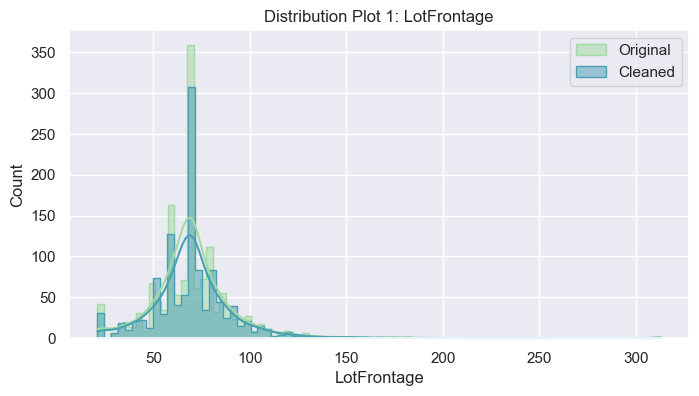

*** Histogram for numerical variable: LotFrontage
*** Distribution Effect Analysis After Data Cleaning Method on variable: BedroomAbvGr


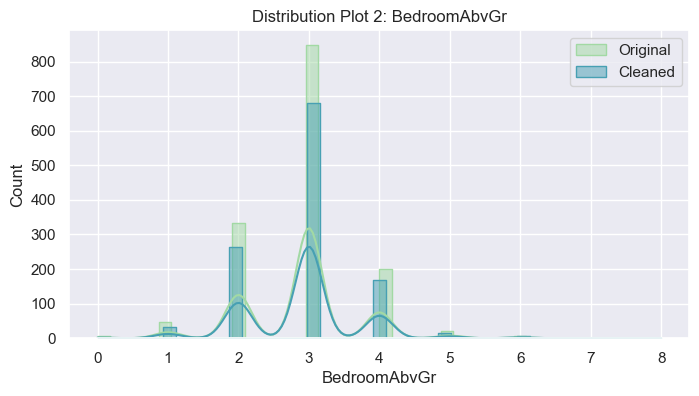

*** Histogram for numerical variable: BedroomAbvGr
*** Distribution Effect Analysis After Data Cleaning Method on variable: GarageFinish


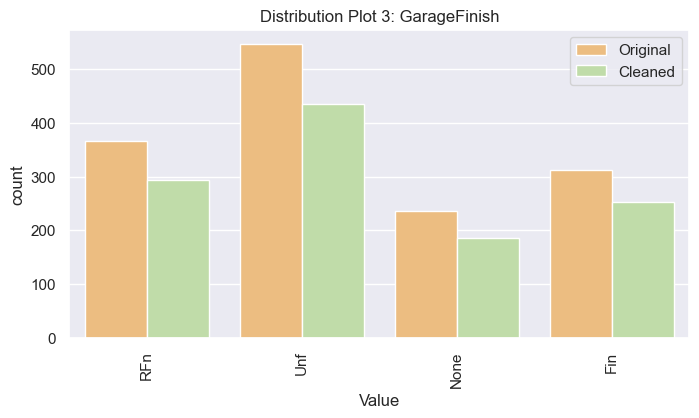

*** Bar plot for categorical variable: GarageFinish
*** Distribution Effect Analysis After Data Cleaning Method on variable: MasVnrArea


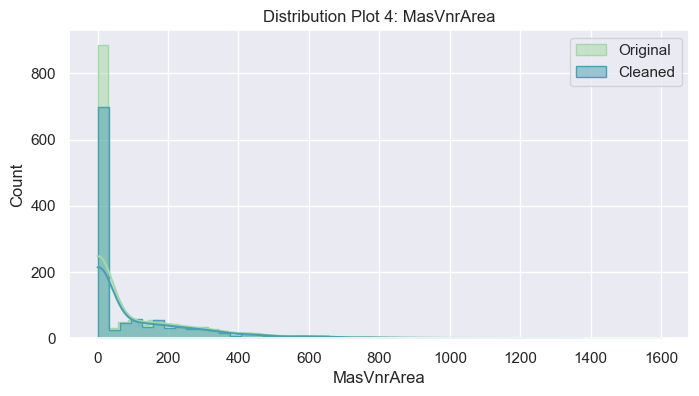

*** Histogram for numerical variable: MasVnrArea


In [110]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Theme
sns.set_theme(style="darkgrid")


def DataCleaningEffect(df_original, df_cleaned, variables_applied_with_method):
    """
    Function to visualize the effect of data cleaning on specified variables using the Spectral palette.
    """
    flag_count = 1

    # Identify categorical variables
    categorical_variables = df_original.select_dtypes(exclude=['number']).columns

    # Loop through every variable in the list
    for var in variables_applied_with_method:
        print(f"*** Distribution Effect Analysis After Data Cleaning Method on variable: {var}")

        if var in categorical_variables:
            # For categorical variables, create a bar chart
            df1 = pd.DataFrame({"Type": "Original", "Value": df_original[var]})
            df2 = pd.DataFrame({"Type": "Cleaned", "Value": df_cleaned[var]})
            dfAux = pd.concat([df1, df2], axis=0)
            dfAux.reset_index(drop=True, inplace=True) 

            fig, axes = plt.subplots(figsize=(8, 4))
            sns.countplot(
                data=dfAux, 
                x="Value", 
                hue="Type", 
                palette=sns.color_palette("Spectral", n_colors=2) 
                )
            axes.set_title(f"Distribution Plot {flag_count}: {var}")
            plt.xticks(rotation=90)
            plt.legend()
            plt.show()
            print(f"*** Bar plot for categorical variable: {var}")

        else:
            # For numeric variables, create histograms
            fig, axes = plt.subplots(figsize=(8, 4))
            sns.histplot(
                data=df_original, 
                x=var, 
                color=sns.color_palette("Spectral")[4],  
                label='Original', 
                kde=True, 
                element="step", 
                ax=axes
                )
            sns.histplot(
                data=df_cleaned, 
                x=var, 
                color=sns.color_palette("Spectral")[5],  
                label='Cleaned', 
                kde=True, 
                element="step", 
                ax=axes
                )
            axes.set_title(f"Distribution Plot {flag_count}: {var}")
            plt.legend()
            plt.show()
            print(f"*** Histogram for numerical variable: {var}")

        plt.close(fig)
        flag_count += 1


# Variables to verify
variables_to_verify = ['LotFrontage', 'BedroomAbvGr', 'GarageFinish', 'MasVnrArea']

# Call function to verify cleaning process
DataCleaningEffect(df_original=df_prices, 
                   df_cleaned=TrainSet, 
                   variables_applied_with_method=variables_to_verify)

---

## Conclusion and Next Steps

### Conclusion
We successfully completed the data cleaning process, ensuring that the dataset is ready for further analysis and modeling. 
Key steps included:
1. **Handling Missing Values**: Missing values were addressed using logical and data-driven methods, such as imputing with the median or filling with appropriate categorical values like 'None'.
2. **Optimizing Data Types**: Categorical columns were converted to the category data type to improve memory efficiency and performance.
1. **Dropping Irrelevant columns**: Columns with a high percentage of missing values or low relevance were removed to streamline the dataset.
2. **Splitting Data**: The dataset was split into TrainSet and TestSet to prepare for modeling, ensuring no missing values remain in either set.
5. **Verification**: Visualizations were used to verify the cleaning process, comparing original and cleaned data to ensure no unexpected changes were introduced.

### Next steps: Correlation Study
1. **Formulate Hypotheses**: Create hypotheses based on selected attributes that are likely to influence the target variable (`SalePrice`).
2. **Analyze Relationship**: Analyze relationships between chosen attributes and `SalePrice` to identify key predictors that can be used in the predictive model.
3. **Visualize Insights**: Use visualizations such as heatmaps, scatterplots, and boxplots to explore and present these relationships in a clear and interpretable manner.

## Save file
Save train and test set to `outputs/datasets/cleaned` directory.

In [114]:
TrainSet.to_parquet("outputs/datasets/cleaned/train_set.parquet", index=False)
TestSet.to_parquet("outputs/datasets/cleaned/test_set.parquet", index=False)